In [1]:
# This is what we gonna use to test our masterpiece
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
print("This Notebook was produced with the following versions:")
print(f"Python version: {sys.version}")

print(xr.__version__)
print(np.__version__)
print(pd.__version__)

This Notebook was produced with the following versions:
Python version: 3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:20:11) [MSC v.1938 64 bit (AMD64)]
2025.3.1
1.26.4
2.2.2


# Disturbance Type Classification (DTC)

The Disturbance Type Classification (DTC) determines whether sediment mobilisation at each location is dominated by:

1. **Wave** (Wave-induced stress mobilizes sediment $(t_w > t_{cr})$ >2× more often than currents)
2. **Tide** (Current-induced stress mobilizes sediment $(t_c > t_{cr})$ >2× more often than waves)  
3. **Mixed** Neither wave nor tidal dominance criteria are met

Source material:
> A classification scheme used for the Australian continental shelf (Porter-Smith et al. 2004) was modified for the disturbance-type classification in the Bay of Fundy. “Tide-dominated” disturbance type applies to locations where the time percentage of mobilization by tidal current is greater than two times that by either waves or circulation current. “Wave-dominated” type and “circulation-dominated” type are similarly defined. Locations that do not fall into any of the aforementioned three types are classified as “mixed-disturbance” type

[& Li et al 2015](https://cdnsciencepub.com/doi/10.1139/cjes-2014-0211#:~:text=A%20classification%20scheme,mixed%2Ddisturbance%E2%80%9D%20type)


### Generate Synthetic Test Data

- *n_lat x n_lon* grid of locations 
- $n$ time steps
- $t_c$ Bed shear stress induced by currents (time-varying, spatially-varying)
- $t_w$: Bed shear stress induced by waves (time-varying, spatially-varying)
- $t_{cr}$: Critical shear stress (constant in time, spatially-varying)

In [53]:
np.random.seed(0)

# Create some synthetic data
longitude = [-5.00, -4.75]
latitude = [50.00, 50.25]
time = pd.date_range("2025-09-26", periods=10)

# Generate random values for each (time, lon, lat)
tc_var = np.round(np.random.rand(len(time), len(longitude), len(latitude)), 1)
tw_var = np.round(np.random.rand(len(time), len(longitude), len(latitude)), 1)
tcr_var = np.round(np.random.rand(len(longitude), len(latitude)), 1)

print(f"Currents stress: {tc_var[:, 0, 0]}")
print(f"Waves stress: {tw_var[:, 0, 0]}")
print(f"Critical stress: {tcr_var[:, 0]}")

# === OR ====

# # Manually defined data (len of values = time dimension, single lon/lat point)
# tc_var = 0.1, 0.2, 0.3, 0.6, 0.5   # Bed shear stress induced by currents
# tw_var = 0.0, 0.0, 0.3, 0.4, 0.5  # Bed shear stress induced by waves
# tcr_var = 0.1  # Critical shear stress for sediment motion

Currents stress: [0.5 0.4 1.  0.6 0.  1.  0.1 0.5 0.5 0.6]
Waves stress: [0.4 0.7 0.3 1.  0.7 0.2 0.2 0.8 1.  0.3]
Critical stress: [0.3 0.1]


### Create xarray DataArrays 

Convert raw data into properly structured xarray DataArrays simular to the Tool input: dimensions `(time, longitude, latitude)`

In [44]:
# --- Create xarray DataArrays for Currents ---
t_c = xr.DataArray(
    data=tc_var, # use this line and comment the next if going to use random GENERATED data
    #data=[[ [v] ] for v in tc_var], # use this line and comment the previous if going to use MANUAL data
    dims=["time", "longitude", "latitude"],
    coords={"time": time, "longitude": longitude, "latitude": latitude},
    name="BSS_current",
    attrs={"description": "Bed shear stress induced by currents", "units": "N/m^2"},
)
t_c

<xarray.DataArray 'BSS_current' (time: 10, longitude: 2, latitude: 2)> Size: 320B
array([[[0.5, 0.7],
        [0.6, 0.5]],

       [[0.4, 0.6],
        [0.4, 0.9]],

       [[1. , 0.4],
        [0.8, 0.5]],

       [[0.6, 0.9],
        [0.1, 0.1]],

       [[0. , 0.8],
        [0.8, 0.9]],

       [[1. , 0.8],
        [0.5, 0.8]],

       [[0.1, 0.6],
        [0.1, 0.9]],

       [[0.5, 0.4],
        [0.3, 0.8]],

       [[0.5, 0.6],
        [0. , 0.6]],

       [[0.6, 0.6],
        [0.9, 0.7]]])
Coordinates:
  * time       (time) datetime64[ns] 80B 2025-09-26 2025-09-27 ... 2025-10-05
  * longitude  (longitude) float64 16B -5.0 -4.75
  * latitude   (latitude) float64 16B 50.0 50.25
Attributes:
    description:  Bed shear stress induced by currents
    units:        N/m^2

In [47]:
# --- Create xarray DataArrays for Waves ---
t_w = xr.DataArray(
    data=tw_var, # use this line and comment the next if going to use random GENERATED data
    # data=[[ [v] ] for v in tw_var], # use this line and comment the previous if going to use MANUAL data
    dims=["time", "longitude", "latitude"],
    coords={"time": time, "longitude": longitude, "latitude": latitude},
    name="BSS_waves",
    attrs={"description": "Bed shear stress induced by waves", "units": "N/m^2"},
)
t_w

<xarray.DataArray 'BSS_waves' (time: 10, longitude: 2, latitude: 2)> Size: 320B
array([[[0.4, 0.4],
        [0.7, 0.1]],

       [[0.7, 0.7],
        [0.2, 0.1]],

       [[0.3, 0.4],
        [0.6, 0.4]],

       [[1. , 0.1],
        [0.2, 0.2]],

       [[0.7, 0.3],
        [0.5, 0.2]],

       [[0.2, 0.1],
        [0.7, 0.1]],

       [[0.2, 0.4],
        [0.8, 0.1]],

       [[0.8, 0.1],
        [1. , 0.5]],

       [[1. , 0.6],
        [0.7, 0. ]],

       [[0.3, 0.1],
        [0.3, 0.1]]])
Coordinates:
  * time       (time) datetime64[ns] 80B 2025-09-26 2025-09-27 ... 2025-10-05
  * longitude  (longitude) float64 16B -5.0 -4.75
  * latitude   (latitude) float64 16B 50.0 50.25
Attributes:
    description:  Bed shear stress induced by waves
    units:        N/m^2

In [54]:
# --- Create xarray DataArrays for Critical shear stress ---
t_cr = xr.DataArray(
    data=tcr_var,
    dims=["longitude", "latitude"],
    coords={"longitude": longitude, "latitude": latitude},
    name="BSS_critical",
    attrs={"description": "Critical shear stress", "units": "N/m^2"},
)
t_cr

<xarray.DataArray 'BSS_critical' (longitude: 2, latitude: 2)> Size: 32B
array([[0.3, 0.4],
       [0.1, 0.7]])
Coordinates:
  * longitude  (longitude) float64 16B -5.0 -4.75
  * latitude   (latitude) float64 16B 50.0 50.25
Attributes:
    description:  Critical shear stress
    units:        N/m^2

### Visualize shear stress components over time for each location

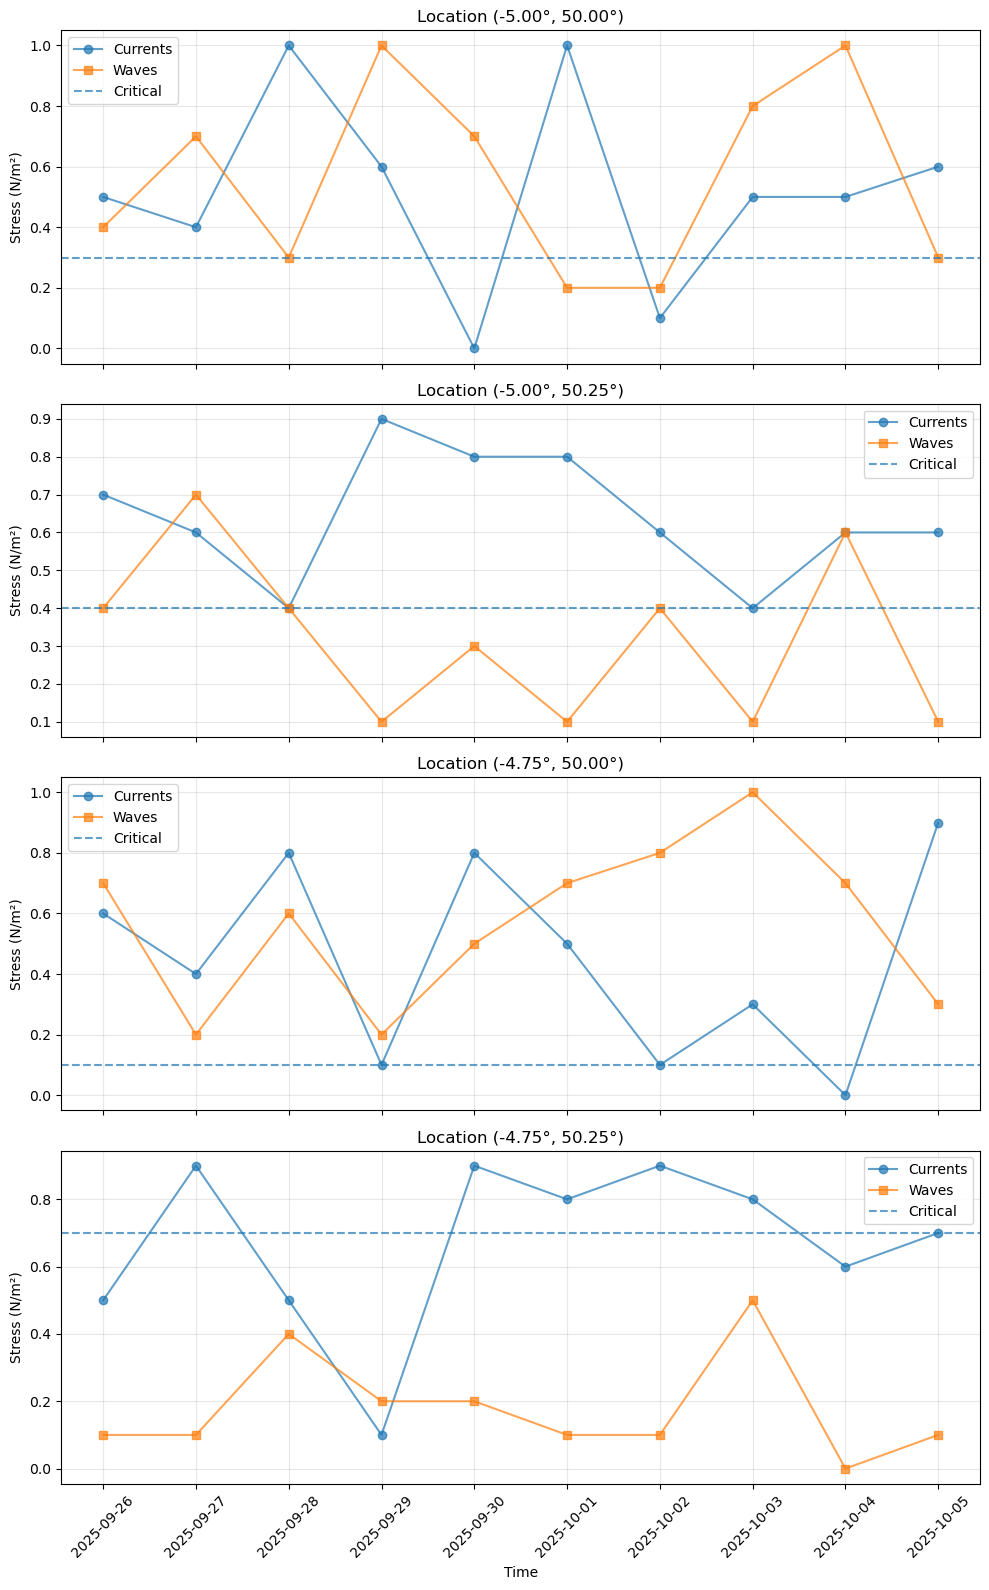

In [55]:
n_locs = len(longitude) * len(latitude)
fig, axes = plt.subplots(n_locs, 1, figsize=(10, 4*n_locs), sharex=True)

if n_locs == 1:
    axes = [axes]  # make iterable if only one subplot

idx = 0
for i, lon in enumerate(longitude):
    for j, lat in enumerate(latitude):
        ax = axes[idx]
        idx += 1
        
        tc_vals = t_c.isel(longitude=i, latitude=j).values
        tw_vals = t_w.isel(longitude=i, latitude=j).values
        tcr_val = t_cr.isel(longitude=i, latitude=j).values

        loc_label = f"({lon:.2f}°, {lat:.2f}°)"
        ax.plot(time, tc_vals, 'o-', label='Currents', alpha=0.7)
        ax.plot(time, tw_vals, 's-', label='Waves', alpha=0.7)
        ax.axhline(y=tcr_val, linestyle='--', alpha=0.7, label='Critical')
        
        ax.set_title(f'Location {loc_label}')
        ax.set_ylabel("Stress (N/m²)")
        ax.legend()
        ax.grid(True, alpha=0.3)

plt.xlabel("Time")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Assign Disturbance Type Classification

1. Determine how often each stress component exceeds critical threshold
2. Convert counts to percentage of total time
3. Use 2× threshold rule to classify locations
4. Assign categories

**Classification Logic:**
``` Python
Wave-dominated: wave exceedance > 2 × tide exceedance  
Tide-dominated: tide exceedance > 2 × wave exceedance
Mixed: Neither dominance condition is met
```

In [56]:
#Count exceedances
wave_dom_count = (t_w > t_cr).sum(dim="time", skipna=True)
tide_dom_count = (t_c > t_cr).sum(dim="time", skipna=True)

# Calculate percentages
total_time = t_w.sizes["time"]
exceedance_percentage_waves = (wave_dom_count / total_time) * 100
exceedance_percentage_tides = (tide_dom_count / total_time) * 100

# Apply dominance criteria
wave_mask = exceedance_percentage_waves > 2 * exceedance_percentage_tides
tide_mask = exceedance_percentage_tides > 2 * exceedance_percentage_waves

# Assing categories based on masks
dtc = xr.where(wave_mask, 1,           # If wave dominant, assign 1
        xr.where(tide_mask, 2, 3))     # Else if tide dominant, assign 2, otherwise 3 (mixed)

# Metadata
dtc.name = "DTC"
dtc.attrs["description"] = "Disturbance Type Classification (1=wave, 2=tide, 3=mixed)"
dtc

<xarray.DataArray 'DTC' (longitude: 2, latitude: 2)> Size: 16B
array([[3, 2],
       [3, 2]])
Coordinates:
  * longitude  (longitude) float64 16B -5.0 -4.75
  * latitude   (latitude) float64 16B 50.0 50.25
Attributes:
    description:  Disturbance Type Classification (1=wave, 2=tide, 3=mixed)

### Results Validation & Interpretation

The debug output helps verify the classification logic by showing: exceedance counts, percentages, logic evaluation and resulting DTC values for each location

In [58]:
print("--- Debugging DTC Logic ---")
# Raw number of threshold-exceeding events
print(f"Wave exceedance count: {wave_dom_count.values}") 
print(f"Tide exceedance count: {tide_dom_count.values}")
print(f"Total time steps: {total_time}")

# Temporal frequency of mobilization events
print(f"Wave exceedance percentage: {exceedance_percentage_waves.values}") 
print(f"Tide exceedance percentage: {exceedance_percentage_tides.values}")

# Step-by-step condition checking
print(f"\nWave > 2 * Tide?\n {exceedance_percentage_waves.values} > {2 * exceedance_percentage_tides.values} = {wave_mask.values}") 
print(f"Tide > 2 * Wave?\n {exceedance_percentage_tides.values} > {2 * exceedance_percentage_waves.values} = {tide_mask.values}")

# Resulting DTC values for each location
print(f"\nDTC result: {dtc.values}")

--- Debugging DTC Logic ---
Wave exceedance count: [[ 6  2]
 [10  0]]
Tide exceedance count: [[8 8]
 [7 5]]
Total time steps: 10
Wave exceedance percentage: [[ 60.  20.]
 [100.   0.]]
Tide exceedance percentage: [[80. 80.]
 [70. 50.]]

Wave > 2 * Tide?
 [[ 60.  20.]
 [100.   0.]] > [[160. 160.]
 [140. 100.]] = [[False False]
 [False False]]
Tide > 2 * Wave?
 [[80. 80.]
 [70. 50.]] > [[120.  40.]
 [200.   0.]] = [[False  True]
 [False  True]]

DTC result: [[3 2]
 [3 2]]
